# Using BLS' CPI Microdata

Semi-automated tool to analyze inflation dynamics every time BLS releases new data

In [ ]:
#import openpyxl
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import namedtuple

The following notebook works with the non-SA data output from the BLS' 'MultiScreen' query tool

https://www.bls.gov/data/home.htm

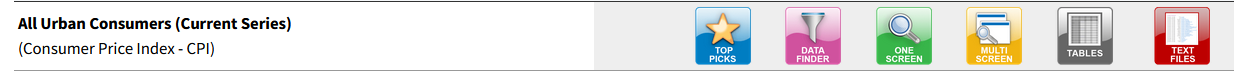

The query tool tends to freeze if we select everything so im making a tiny compromise and outputing just un-SA data from the following 14 geo areas

- 0000 U.S City Average
- 0100 Northeast
- 0110 New England
- 0120 Middle Atlantic
- 0200 Midwest
- 0230 East North Central
- 0240 West North Central
- 0300 South
- 0350 South Atlantic
- 0360 East South Central
- 0370 West South Central
- 0400 West
- 0480 Mountain
- 0490 Pacific

In [ ]:
# Working directory setup

os.chdir('/Inflation')
current_directory = os.getcwd()
files_in_directory = os.listdir(current_directory)

print("Files in current working directory:")
for file_name in files_in_directory:
    print(file_name)

In [ ]:
# File uploaded is the BLS data series as the query outputs it, just renamed it to make it tidyier
# i dropped rows 1-3 before loading the dataframe, i have pending to integrate that step into the script

cpi=pd.read_excel('cpi_bls23.xlsx', sheet_name='BLS Data Series')

In [ ]:
cpi.head()

### Basic wrangling and dataframe setup

In [ ]:
# don't want the half year and annual mark columns

patterns = ['half', 'annual']
matching_columns = [col for col in cpi.columns
                        if any(re.search(pattern, col, re.IGNORECASE)for pattern in patterns)]

print(len(matching_columns), "columns found with pattern to be dropped")
cpi=cpi.drop(matching_columns, axis=1)

# plus editing the odd column formatting

new_colnames=[c.replace('\n', '-') for c in cpi.columns]
cpi.columns=new_colnames

#### Understanding codification

Item codes have variable lenghts conditional on the aggregation level, so series_id lenght tells me the agg level implicitly

SA0 is the overal index, then goes SA1,2,3 for each aggregate which then unrolls into larger strings, making the whole code longer

Series name and area code are fixed, so overall stringh length depends entirely on the item code. i'll extract the item cosed based on this knowledge

In [ ]:
print("min and max length for series ID: ")
print(cpi['Series ID'].str.len().min())
print(cpi['Series ID'].str.len().max())
cpi['id_len']=cpi['Series ID'].str.len()

In [ ]:
#4 digits for series name + 4 digits for area code; the rest is item code, so we know how to extract that substring

conditions = [ #note, these are already Series that say true/false for each row
    cpi['id_len'] == 11,
    cpi['id_len'] == 12,
    cpi['id_len'] == 13,
    cpi['id_len'] == 14,
    cpi['id_len'] == 15,
    cpi['id_len'] == 16
]

# by taking out 8 , we know what chars to substring

chars_to_substring=[3,4,5,6,7,8]

In [ ]:
# extracting item and area code

cpi['item_code']='foo_item'
cpi['area_code']='foo_area'
cuur=len('CUUR') #inflation code, marks the start of the item code

for index, row in cpi.iterrows():
    for condition, substring in zip(conditions, chars_to_substring):
        if condition[index]==True:
            cpi.at[index, 'item_code']=cpi.at[index,'Series ID'][-substring:]
            cpi.at[index, 'area_code']=cpi.at[index,'Series ID'][cuur:-substring:]
            break # given that booleans are independent we can pass upon the first true

In [ ]:
code_to_area={
    '0000': 'U.S City Average',
    '0100': 'Northeast',
    '0110': 'New England',
    '0120': 'Middle Atlantic',
    '0200': 'Midwest',
    '0230': 'East North Central',
    '0240': 'West North Central',
    '0300': 'South',
    '0350': 'South Atlantic',
    '0360': 'East South Central',
    '0370': 'West South Central',
    '0400': 'West',
    '0480': 'Mountain',
    '0490': 'Pacific',
}

cpi['area_descr']=cpi.area_code.map(code_to_area)

In [ ]:
cpi.head()

Fetching the descriptions and weights of the index is not as straightforward as one would hope.

Descriptions are available in this really odd shaped file

https://download.bls.gov/pub/time.series/cu/cu.item

and then the weights are matched by description and not code in this site

https://www.bls.gov/cpi/tables/relative-importance/home.htm

I contacted BLS and they provided an aggregation tree with codes and weights which is not perfect but it is what it is

In [ ]:
#weights are only appropiate for the all city index so we'll merge that bit of the time series with the tree
all_city_cpi=cpi[cpi['area_code']=='0000']

print("all areas cpi has shape ",cpi.shape)
print("cpi for us average has shape ",all_city_cpi.shape)

In [ ]:
agg_tree=pd.read_excel('Aggregation Tree.xlsx', sheet_name='Tree')
agg_tree=agg_tree.drop(1) #i have no interest in the old base index
agg_tree.head()

In [ ]:
# next step is to merge the tree and the time series, the rest is a bit of dropping and rearranging to make more readable
cpi_tree=agg_tree.loc[:,['Branch','Condensed code', 'Condensed descr', 'Weight']]
cpi_tree=pd.merge(cpi_tree,all_city_cpi,how='left', left_on='Condensed code', right_on='item_code')
cpi_tree=cpi_tree.drop(['id_len','Condensed code'], axis=1)

#re-ordering categories
cpi_tree = pd.concat([cpi_tree.iloc[:, -2:], cpi_tree.iloc[:, :-2]], axis=1)
cpi_tree.head()

In [ ]:
# the tree has provided with the weight and the aggregation branch for each item
print(cpi_tree['Branch'].value_counts())

# note: the tree is designed just to sum up to 100 for the first three branches
cpi_tree.groupby('Branch').Weight.sum()

I'm going to create columns to better locate items along the branches,for this im adding each code an indicator of what branches it comes from. Food --> Bakery --> Bread

Note: this snippet takes advantage of the fact that the tree is ordered by categories. So for example all of the Food branch is unfolded before passing to the next category that is at the same aggregation level.If the sorting of the file is altered before importing, then this wont work

Basically what this does is "if the branch number equals number "B" (current description to be fetch), fetch the description from the row above, if its lower just return a NaN and it is higher fetch that of the row above (given that it is ordered this makes the code repeat the same description over and over until a new branch of the same aggregation level comes)

In [ ]:
cpi_tree['Branch1_descr']='foo'

for index, row in cpi_tree.iterrows():
    if cpi_tree.at[index,'Branch']==0:
        cpi_tree.at[index,'Branch1_descr']=np.nan
    elif cpi_tree.at[index,'Branch']==1:
        cpi_tree.at[index,'Branch1_descr']= cpi_tree.at[index,'Condensed descr']
    else:
        cpi_tree.at[index,'Branch1_descr']= cpi_tree.at[index-1,'Branch1_descr']   
cpi_tree['Branch2_descr']='foo'

for index, row in cpi_tree.iterrows():
    if cpi_tree.at[index,'Branch']<2:
        cpi_tree.at[index,'Branch2_descr']=np.nan
    elif cpi_tree.at[index,'Branch']==2:
        cpi_tree.at[index,'Branch2_descr']= cpi_tree.at[index,'Condensed descr']
    else:
        cpi_tree.at[index,'Branch2_descr']= cpi_tree.at[index-1,'Branch2_descr']
        
cpi_tree['Branch3_descr']='foo'

for index, row in cpi_tree.iterrows():
    if cpi_tree.at[index,'Branch']<3:
        cpi_tree.at[index,'Branch3_descr']=np.nan
    elif cpi_tree.at[index,'Branch']==3:
        cpi_tree.at[index,'Branch3_descr']= cpi_tree.at[index,'Condensed descr']
    else:
        cpi_tree.at[index,'Branch3_descr']= cpi_tree.at[index-1,'Branch3_descr']

### Plotting

In [ ]:
# two functions to get and plot data

def get_cpi_data(item_code,start='Jan-1980',end='Dec-2023'):
    matching_index = (cpi_tree['item_code'] == item_code).idxmax()
    
    start_column=cpi_tree.columns.get_loc(start)
    end_column=cpi_tree.columns.get_loc(end)
    selection=cpi_tree.iloc[matching_index,start_column:end_column]
        
    return selection,item_code

def plot_trend(code,start='Jan-1980',end='Dec-2023'):
    get_cpi_data(code, start, end)[0].plot()
    plt.legend(cpi_tree.loc[cpi_tree.item_code==code,'Condensed descr'])
    
def get_branch(branch, period='Nov-2023', baseline=12, print_warnings=False):
    selected_df=cpi_tree[cpi_tree['Branch']==branch]
    selected_df=selected_df.iloc[:,[selected_df.columns.get_loc('Condensed descr'),
                                    selected_df.columns.get_loc('Weight'),
                                    selected_df.columns.get_loc(period)-baseline,
                                   selected_df.columns.get_loc(period)]]
    selected_df['Var%']=(selected_df.iloc[:,3]/selected_df.iloc[:,2]-1)*100
    no_weight=selected_df.Weight.isna().sum()
    if print_warnings==True:
        print("get_branch warnings:")
        print(f"{no_weight} rows with no data were dropped")
    selected_df=selected_df[selected_df[period].notna()]
    if print_warnings==True:
        print("weight total:",selected_df.Weight.sum())
        print("****"*10)
    selected_df=selected_df.sort_values(by='Var%', ascending=False)
    selected_df.set_index('Condensed descr', inplace=True)
    return period,selected_df,branch

In [ ]:
for b in [0,1,2,3]:
    print("*"*20)
    print(f"Main overview: branch {b}")
    print("*"*20)
    branch_data=get_branch(b)
    ax = branch_data[1].plot(y='Var%', kind='bar')
    if b>2:
        ax.set_xticklabels([])
    plt.show()
    ##
    print(f"Top increases {branch_data[0]} at aggregation level {branch_data[2]}")
    print(branch_data[1].head(10).loc[:,['Weight','Var%']],"\n")
    print(f"Top decreases {branch_data[0]} at aggregation level {branch_data[2]}")
    print(branch_data[1].tail(10).loc[:,['Weight','Var%']],"\n")
    print("\n\n")